In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.examples.tutorials.mnist import mnist
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Parameters

In [2]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
img_shape = (IMAGE_SIZE, IMAGE_SIZE)

input_data_dir = '/tmp/tensorflow/mnist/input_data'
batch_size = 100
learning_rate = 0.01
max_steps = 2000
hidden1_units = 128
hidden2_units = 32
log_dir = '/tmp/tensorflow/mnist/logs/fully_connected_feed'

In [3]:
IMAGE_PIXELS

784

# The dataset

In [4]:
data_sets = input_data.read_data_sets(input_data_dir, False)

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [5]:
data_sets.train.images.shape

(55000, 784)

In [6]:
data_sets.test.images.shape

(10000, 784)

In [7]:
data_sets.train.labels.shape

(55000,)

In [8]:
data_sets.test.labels.shape

(10000,)

In [9]:
images = data_sets.test.images[0:9]

In [10]:
def plot_images(images):
   
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        #ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

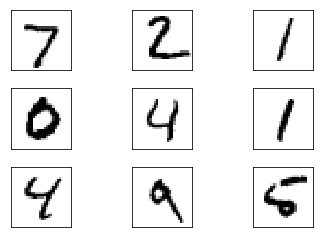

In [11]:
plot_images(images)

# Create placeholders

In [12]:
images_placeholders = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_PIXELS))

In [13]:
images_placeholders

<tf.Tensor 'Placeholder:0' shape=(100, 784) dtype=float32>

In [14]:
labels_placeholders = tf.placeholder(tf.float32, shape=(batch_size))
labels_placeholders

<tf.Tensor 'Placeholder_1:0' shape=(100,) dtype=float32>

In [22]:
def placeholder_inputs(batch_size):
    images_placeholders = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_PIXELS))
    labels_placeholders = tf.placeholder(tf.float32, shape=(batch_size))
    return images_placeholders, labels_placeholders

# Build the graph

We use a `name_scope` that acts as a prefix to the items created. This avoids names collision.

In [15]:
def inference(images, hidden1_units, hidden2_units):
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                               stddev= 1.0 / math.sqrt(float(IMAGE_PIXELS))), # Xavier Glorot initialization
            name='weights')

        biases = tf.Variable(tf.zeros([hidden1_units]), 
                          name='biases')

        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)

    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                               stddev= 1.0 / math.sqrt(float(hidden1_units))),
            name='weights')

        biases = tf.Variable(tf.zeros([hidden2_units]),
                            name='biases')

        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)

    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(tf.truncated_normal([hidden2_units, NUM_CLASSES],
                                                 stddev= 1.0 / math.sqrt(float(hidden2_units))),
                             name='weights')

        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                            name='biases')

        logits = tf.matmul(hidden2, weights) + biases
    return logits

In order to produce output that follow a similar distribution across all nerons, we need to initialise our weights with unit variance. Thus we need to scale our random normal weights by **`1/sqrt(n)`** in order to have unit variance (Xavier Glorot paper).
Found simplified explanations in [this](https://theneuralperspective.com/2016/11/11/weights-initialization/) blog post.

# Define loss

In [16]:
def loss_fn(logits, labels):
    labels = tf.to_int64(labels)  # why convert to int64 when the cross entropy function accepts int32?
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=labels, logits=logits, name='xentropy')
    
    return tf.reduce_mean(cross_entropy, name='xentropy_mean')

# Minimize the loss via GradientDescent

In [17]:
def training(loss, learning_rate):
    # log
    tf.summary.scalar("loss", loss)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    # Variable to log the global step
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Use the optimizer to apply the gradients that minimize the loss and increment the global_step counter
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    return train_op

# Evaluation

In [18]:
def fill_feed_dict(data_set, image_pl, labels_pl):
    images_feed, labels_feed = data_set.next_batch(batch_size)
    feed_dict = {
        image_pl: images_feed,
        labels_pl: labels_feed
    }
    return feed_dict

In [19]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [20]:
def do_eval(sess,
           eval_correct,
           images_placeholders,
           labels_placeholders,
           data_set):
    true_count = 0
    steps_per_epoch = data_set.num_examples // batch_size
    num_examples = steps_per_epoch * batch_size
    
    for step in xrange(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set, images_placeholders, labels_placeholders)
        true_count += sess.run(eval_correct, feed_dict=feed_dict)
    
    precision = float(true_count) / num_examples
    print('  Num examples: %d Num correct: %d Precision @ 1: %0.04f' % 
         (num_examples, true_count, precision))

# The training loop

In [23]:
with tf.Graph().as_default():
    # generate placehoders
    images_placeholders, labels_placeholders = placeholder_inputs(batch_size)
    # build the graph
    logits = inference(images_placeholders,hidden1_units, hidden2_units)
    
    # Add to the graph the Ops for loss calculation
    loss = loss_fn(logits, labels_placeholders)
    
    # Add to the graph the Ops that calculate and apply gradients
    train_op = training(logits, learning_rate)
    
    # Add the Op to compare the logits to the labels during evaluation
    eval_correct = evaluation(logits, labels_placeholders)
    
    # Build the summary tensor based on the TF collection of Summaries
    summary = tf.summary.merge_all()
    
    # Add the variable initializer Op
    init = tf.global_variables_initializer()
    
    # Create a saver for writing training checkpoints
    saver = tf.train.Saver()
    
    # Create a session for running Ops on the Graph
    sess = tf.Session()
    
    # Instantiate a SummaryWriter to output summaries and the Graph
    summary_writer = tf.summary.FileWriter(log_dir, sess.graph)
    
    # Run the Op to initialize the variables
    sess.run(init)
    
    # Start the training loop
    for step in xrange(max_steps):
        start_time = time.time()
        
        # Fill a feed_dict
        feed_dict = fill_feed_dict(data_sets.train,images_placeholders, labels_placeholders)
        
        # running
        _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
        
        # timer
        duration = time.time() - start_time
        
        # write summaries and print overview
        if step % 100 == 0:
            print("Step %d: loss = %.2f (%.3f sec)" % (step, loss_value, duration))
            
            #Update the events file
            summary_str = sess.run(summary, feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, step)
            summary_writer.flush()
            
        # Save a checkpoint and evaluate the model 
        if (step + 1) % 1000 == 0 or (step + 1) == max_steps:
            checkpoint_file = os.path.join(log_dir, 'model.ckpt')
            saver.save(sess, checkpoint_file, global_step=step)
            
            #Evaluate the training set
            print("Training data eval:")
            do_eval(sess,
                   eval_correct,
                   images_placeholders,
                   labels_placeholders,
                   data_sets.train)
            
            #Evaluate the validation set
            print("Validation data eval:")
            do_eval(sess,
                   eval_correct,
                   images_placeholders,
                   labels_placeholders,
                   data_sets.validation)
            
            #Evaluate the test set
            print("Test data eval:")
            do_eval(sess,
                    eval_correct,
                   images_placeholders,
                   labels_placeholders,
                   data_sets.test)

TypeError: Value passed to parameter 'targets' has DataType float32 not in list of allowed values: int32, int64